## Potential Talents - Part 4

----

# Job Title Similarity using LLMs-as-Rankers

### Objectives
Retrieve the most similar job titles to a query **using LLMs as deterministic rankers** and compare their rankings against the **existing embeddings + cosine** baseline.

### Constraints
- Local execution on **GTX 1080 Ti**.
- **Deterministic** decoding (no sampling): `temperature=0`.
- Score **only** from the provided list of 105 titles; **no generation** of new titles.
- LLM outputs are **numeric similarity scores (0–100)** in strict JSON, then ranked.

### Models (initial)
- **FLAN-T5-Large** (🤗, encoder–decoder).
- **Phi-3-mini-4k-instruct** (🤗).  

### Method Overview
- **Baseline (done already at part 3):** embeddings + cosine similarity → per-query rankings and scores.
- **LLM-as-Ranker:** for each `(query, title)` ask the model for an integer score **0–100**
  Batch candidates to keep context small; parse JSON; rank by score.
  
### Display & Evaluation
- **Notebook display:** same format as before  
  Query: <query>
   0.793 <title_raw>
   0.748 <title_raw>

- **Files:** per-model/per-query CSV with `id, score_llm, rank_llm, title_raw, title_clean`.
- **Comparison metric:** **nDCG@k** (reuse function from the embedding notebook, part 3).  

---

## Summary / Roadmap

0) Setup & Data  
1) Load **baseline results** (embeddings + cosine) for each query  
2) Load **LLM model** (start with FLAN-T5-Large)  
3) **Prompt & batch scoring** → JSON `{id, score}`  
4) Build **LLM ranking** and **print** in the prior format; save CSV  
5) **Compare** to baseline via **nDCG@k**  
6) Repeat Steps 2–5 for **Phi-3-mini**  
7) Create a **short summary table** (per model × query)



----


### Step 0 - Imports, config, folders

In [3]:
# core
import os, json, math, re, random, time
import numpy as np
import pandas as pd

# HF
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [5]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# paths
DATA_DIR = "data"
OUT_DIR  = "outputs"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

QUERIES = ["data scientist", "machine learning engineer", "backend developer", "product manager"]  # same queries from Part 3

### Step 1 - Load titles and make a clean field

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, "potential_talents.csv"))

In [7]:
titles = df["job_title"].astype(str).tolist()
len(titles), titles[:5]

(104,
 ['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional',
  'Native English Teacher at EPIK (English Program in Korea)',
  'Aspiring Human Resources Professional',
  'People Development Coordinator at Ryan',
  'Advisory Board Member at Celal Bayar University'])

## 0. Setup & Data

In [6]:
import os, math, random
import numpy as np
import pandas as pd
import torch
from torch import nn
import sys

In [7]:
print("python:", sys.executable)
print("torch file:", torch.__file__)
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())

python: e:\Devs\pyEnv-1\venvs\Pot-Tals_3_env\Scripts\python.exe
torch file: e:\Devs\pyEnv-1\venvs\Pot-Tals_3_env\Lib\site-packages\torch\__init__.py
torch version: 2.6.0+cu124
torch.version.cuda: 12.4
cuda available: True


In [8]:
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [9]:
df = pd.read_csv("./data/potential_talents.csv")
titles = df["job_title"].astype(str).tolist()
len(titles), titles[:5]


(104,
 ['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional',
  'Native English Teacher at EPIK (English Program in Korea)',
  'Aspiring Human Resources Professional',
  'People Development Coordinator at Ryan',
  'Advisory Board Member at Celal Bayar University'])

## 1. Custom SGNS embeddings (from Part 2, mini-Word2Vec)

In [10]:
# Load SGNS checkpoint (from Part 2)
ckpt_path = "checkpoints/sgns_text8.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")


In [11]:
ckpt.keys()

dict_keys(['model_state', 'itos', 'config'])

In [12]:
ckpt['config'] 

{'embed_dim': 300}

In [13]:
ckpt['itos'][:10] 

['a', 'aa', 'aaa', 'aaaa', 'aaai', 'aaas', 'aac', 'aachen', 'aafc', 'aage']

In [14]:
print(type(ckpt['model_state']))
print(ckpt['model_state'].keys())

<class 'collections.OrderedDict'>
odict_keys(['emb_in.weight', 'emb_out.weight'])


In [15]:
itos = ckpt["itos"]
stoi = {w:i for i,w in enumerate(itos)}

E_in  = ckpt["model_state"]["emb_in.weight"].detach().float()   # [|V|, D]
E_out = ckpt["model_state"]["emb_out.weight"].detach().float()  # [|V|, D]

# as in Part2, use the avg 
E_comb = 0.5 * (E_in + E_out)
E_comb = E_comb / (E_comb.norm(dim=1, keepdim=True) + 1e-12)

E_comb.shape


torch.Size([71290, 300])

## 2) Tokenization for titles (keep it simple & consistent)

In [16]:
import re, unicodedata
import nltk
_ = nltk.download('punkt', quiet=True)

In [17]:
# regex for separator chars to normalize/split title delimiters
SEP_RE = re.compile(r"[|/\\•·–—\-]+")      

def canonicalize_title(s: str, strip_org_tail: bool = True) -> str:
    """
    Light canonicalization (cleaning) that preserves full sentence content:
    - Unicode NFKC normalization, trim, lowercase
    - Normalize separators (& -> 'and')
    - Collapse whitespace
    Input: string → Output: cleaned string.
    """
    
    # if the input isn’t a string, return an empty string
    if not isinstance(s, str): 
        return ""
    
    # Unicode normalization form NFKC + strip + lowercase
    s = unicodedata.normalize("NFKC", s).strip().lower()
    s = SEP_RE.sub(" ", s)                 # “hr manager | engie” -> “hr manager  engie”
    s = s.replace("&", " and ")
        
    # collapses any run of whitespace (spaces, tabs) to a single space
    s = re.sub(r"\s+", " ", s)
    
    return s

In [18]:
# Simple, stable regex tokenizer: keep a–z sequences (no stopword/org stripping)
TOKEN_RE = re.compile(r"[a-z]+")

def tokenize_title(s: str, drop_org_like=True) -> list[str]:
    """
    Canonicalize, then regex-tokenize. No stopword/org filtering.
    Input: string → Output: list of tokens.
    """ 
    s = canonicalize_title(s)
    # every sequence of [a-z]+ becomes one token
    toks = TOKEN_RE.findall(s)
    
    return toks

In [67]:
# Build shared columns (used by ALL embedding families)
df["title_text"] = df["job_title"].apply(canonicalize_title)   # full sentence, orgs kept
df["tokens"]     = df["title_text"].apply(tokenize_title)      # tokens, same for every embedding family

# Queries to evaluate later
QUERIES = ["data scientist", "machine learning engineer", "backend developer", "product manager"]
# Tokens of those queries (same tokenizer as titles)
Q_TOKENS = {t for q in QUERIES for t in tokenize_title(q)}

# Peek
df[["job_title", "title_text", "tokens"]].head(10)


,job_title,title_text,tokens
0,2019 C.T. Bauer College of Business Graduate (...,2019 c.t. bauer college of business graduate (...,"[c, t, bauer, college, of, business, graduate,..."
1,Native English Teacher at EPIK (English Progra...,native english teacher at epik (english progra...,"[native, english, teacher, at, epik, english, ..."
2,Aspiring Human Resources Professional,aspiring human resources professional,"[aspiring, human, resources, professional]"
3,People Development Coordinator at Ryan,people development coordinator at ryan,"[people, development, coordinator, at, ryan]"
4,Advisory Board Member at Celal Bayar University,advisory board member at celal bayar university,"[advisory, board, member, at, celal, bayar, un..."
5,Aspiring Human Resources Specialist,aspiring human resources specialist,"[aspiring, human, resources, specialist]"
6,Student at Humber College and Aspiring Human R...,student at humber college and aspiring human r...,"[student, at, humber, college, and, aspiring, ..."
7,HR Senior Specialist,hr senior specialist,"[hr, senior, specialist]"
8,Student at Humber College and Aspiring Human R...,student at humber college and aspiring human r...,"[student, at, humber, college, and, aspiring, ..."
9,Seeking Human Resources HRIS and Generalist Po...,seeking human resources hris and generalist po...,"[seeking, human, resources, hris, and, general..."


## 3) Custom mini-Word2Vec: 

This implementation follows **Skip-Gram with Negative Sampling** in PyTorch with two embedding tables: $E_{\text{in}}$ (centers) and $E_{\text{out}}$ (contexts). For each (center, positive) pair, it samples $K$ negatives and optimizes the SGNS objective above. To form final word vectors, it uses the **average** of the two tables,
$$
E_{\text{comb}}=\tfrac{1}{2}\big(E_{\text{in}}+E_{\text{out}}\big),
$$
then encodes a title by averaging its in-vocab word vectors and searches via **cosine similarity**. This keeps training and inference lightweight while capturing useful semantic structure.

### 3.1) Encode a title as the mean of its word vectors

In [20]:
E = E_comb

@torch.no_grad()
def encode_tokens_mean(tokens: list[str], E: torch.Tensor, stoi: dict) -> torch.Tensor | None:
    idxs = [stoi[t] for t in tokens if t in stoi]
    if not idxs:
        return None
    v = E[idxs].mean(dim=0)                 # [D]
    return v / (v.norm() + 1e-12)

@torch.no_grad()
def encode_title_mean(text: str, E: torch.Tensor, stoi: dict) -> torch.Tensor | None:
    return encode_tokens_mean(tokenize_title(text), E, stoi)

In [21]:
# Rebuild title matrix using df["tokens"] (shared preprocessing)
vecs, keep_idx = [], []
for i, toks in enumerate(df["tokens"]):
    v = encode_tokens_mean(toks, E, stoi)
    if v is not None:
        vecs.append(v); keep_idx.append(i)

X_sgns_mean = torch.stack(vecs)  # [N_kept, D], rows are L2-normalized
print("encoded titles:", X_sgns_mean.shape, "kept rows:", len(keep_idx), "of", len(df))


encoded titles: torch.Size([104, 300]) kept rows: 104 of 104


In [22]:
X_sgns_mean[0] 

tensor([ 0.0102, -0.0397,  0.0605, -0.0698, -0.0451, -0.0469,  0.0385, -0.0740,
         0.0400, -0.0557, -0.0359,  0.0659,  0.0657, -0.0421, -0.0308,  0.0900,
         0.0729,  0.0266,  0.0625, -0.0746,  0.0684, -0.0777, -0.0475, -0.0569,
        -0.0385, -0.0662,  0.0363, -0.0352,  0.0336, -0.0520, -0.0362, -0.0415,
        -0.0313, -0.0825,  0.0237, -0.0868,  0.0350, -0.0584, -0.0503, -0.0151,
        -0.0609,  0.0724, -0.0663, -0.0268,  0.0566, -0.0289, -0.0805,  0.0526,
         0.0408, -0.0282,  0.0904,  0.0533, -0.0580, -0.0389,  0.0214,  0.0406,
         0.0169, -0.0786,  0.0762,  0.0449,  0.0346,  0.0671, -0.1035,  0.0652,
         0.0573, -0.0475, -0.0698,  0.0104,  0.0614, -0.0513,  0.0431, -0.0888,
        -0.0016,  0.0719,  0.0592,  0.0448,  0.0400,  0.0439,  0.0604, -0.0345,
         0.0523, -0.0517, -0.0570, -0.0236,  0.0325, -0.0366, -0.0302, -0.0621,
        -0.0702, -0.0622, -0.0323, -0.0287,  0.0569,  0.0271,  0.0420,  0.0780,
        -0.0658,  0.0758,  0.0521,  0.04

In [23]:
import matplotlib.pyplot as plt

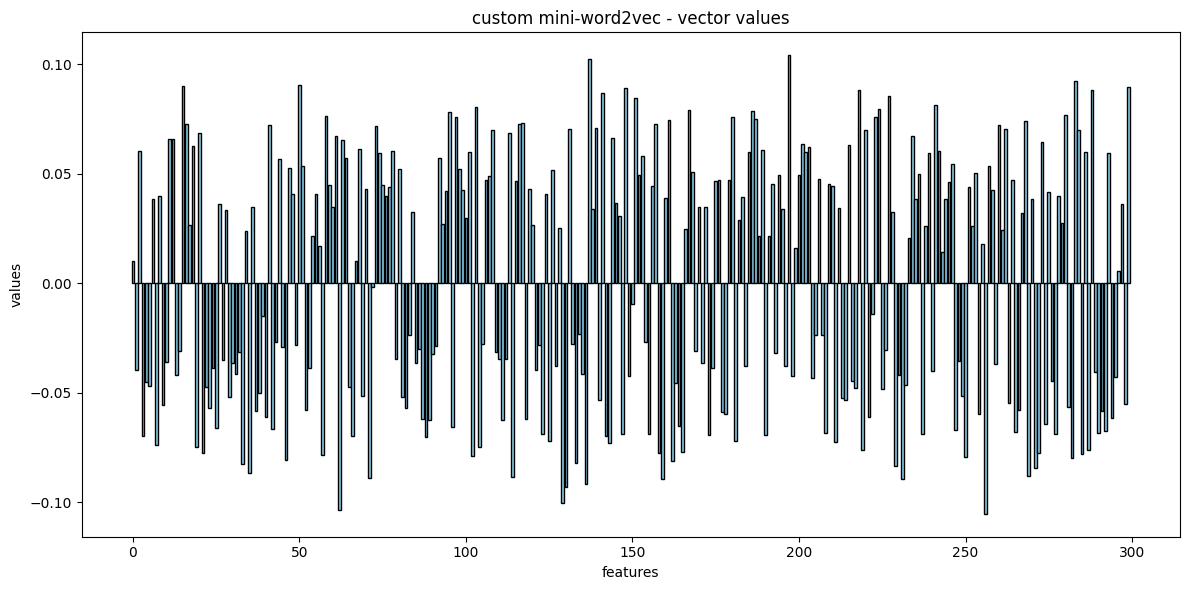

In [24]:
plt.figure(figsize=(12, 6))
plt.bar(range(300), X_sgns_mean[0], color='skyblue', edgecolor='black')
plt.title("custom mini-word2vec - vector values")
plt.xlabel("features")
plt.ylabel("values")
plt.tight_layout()
plt.show()

### 3.2) Cosine search over titles (dot product of normalized vectors)

Cosine search over titles: one function we can reuse for SGNS(mini-Word2Vec)/GloVe/FastText by swapping E, stoi, X, keep_idx.

In [25]:
# search using cosine similarity
@torch.no_grad()
def search_titles(query: str,
                  X: torch.Tensor,
                  E: torch.Tensor,
                  stoi: dict,
                  keep_idx: list[int],
                  df: pd.DataFrame,
                  topk: int = 10,
                  dedupe: bool = True):
    
    # encode query with the SAME tokenizer
    q_tokens = tokenize_title(query)
    q = encode_tokens_mean(q_tokens, E, stoi)
    if q is None:
        return [], "Query has no in-vocab tokens."

    sims = (X @ q)                                      # cosine = dot (rows normalized)
    top = torch.topk(sims, k=min(topk*3, sims.numel())) # oversample if deduping

    rows = []
    seen = set()
    for idx in top.indices.tolist():
        row_id = keep_idx[idx]
        title_str = df.loc[row_id, "job_title"]            # <-- key used for dedupe
        if dedupe:
            if title_str in seen:                          # <-- duplicates dropped
                continue
            seen.add(title_str)
        rows.append((title_str, float(sims[idx].item())))
        if len(rows) == topk:
            break
    return rows, None




In [26]:
# quick test
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    res, err = search_titles(q, X_sgns_mean, E, stoi, keep_idx, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err: print("  ", err)
    else:
        for t, s in res:
            print(f"  {s: .3f}  {t}")



Query: data scientist
   0.793  Information Systems Specialist and Programmer with a love for data and organization.
   0.748  Junior MES Engineer| Information Systems
   0.731  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.729  Human Resources professional for the world leader in GIS software
   0.727  Business Intelligence and Analytics at Travelers
   0.714  Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis
   0.706  Undergraduate Research Assistant at Styczynski Lab
   0.706  Student at Indiana University Kokomo - Business Management - 
Retail Manager at Delphi Hardware and Paint
   0.702  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
   0.701  Business Management Major and Aspiring Human Resources Manager

Query: machine learning engineer
   0.825  Junior MES Engineer| Information Systems


## 4) Experiment with the GoogleNews Word2Vec vectors (Google, 2013)

Word2Vec learns dense vectors so that words sharing contexts have nearby embeddings. In the **skip-gram** view, for a center word $w_t$ it predicts surrounding words $w_{t+j}$. Training usually uses **negative sampling** to replace the full softmax with a small binary task per pair. The classic per-example objective is
$$
\log \sigma(u_{w_t}^\top v_{w_{t+j}})\;+\;\sum_{k=1}^{K}\log \sigma\!\left(-\,u_{w_t}^\top v_{n_k}\right),
$$
where $u$ is the input (center) embedding, $v$ the output (context) embedding, and $n_k$ are sampled “negative” words. The GoogleNews model provides pretrained 300-d vectors trained on a very large corpus.


In [28]:
from gensim.models import KeyedVectors


In [29]:
W2V_PATH = r"./data/GoogleNews-vectors-negative300.bin"

In [30]:
# Load the binary GoogleNews KeyedVectors
w2v = KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)
print("w2v vocab:", len(w2v), "dim:", w2v.vector_size)

w2v vocab: 3000000 dim: 300


### 4.1) Encode tokens

Keep the same functions (encode_tokens_mean, encode_title_mean, search_titles) and the same flow.

In [31]:
# 1) Collect the words we actually need from the dataset
needed = sorted({t for toks in df["tokens"] for t in toks if t in w2v.key_to_index})
needed_not_in_w2v = sorted({t for toks in df["tokens"] for t in toks if t not in w2v.key_to_index})
needed_len = len(needed)
needed_total = needed_len + len(needed_not_in_w2v)
print("needed tokens in w2v:", len(needed), "out of", needed_total)

needed tokens in w2v: 174 out of 199


In [32]:
# 2) Build stoi and E (normalized rows) for just those words
stoi_w2v = w2v.key_to_index
E_w2v = torch.from_numpy(w2v.vectors)              # shares memory
E_w2v = E_w2v / (E_w2v.norm(dim=1, keepdim=True)+1e-12)

In [33]:
# E_w2v (torch) + stoi_w2v (dict) match the previous SGNS interface
print(E_w2v.shape, len(stoi_w2v))

torch.Size([3000000, 300]) 3000000


Encode tokens per title and then calculate the mean value for the title embeddings.

In [34]:
vecs_w2v, keep_idx_w2v = [], []
for i, toks in enumerate(df["tokens"]):
    v = encode_tokens_mean(toks, E_w2v, stoi_w2v) 
    if v is not None:
        vecs_w2v.append(v); keep_idx_w2v.append(i)

X_w2v_mean = torch.stack(vecs_w2v)   # rows already normalized
print("w2v encoded titles:", X_w2v_mean.shape)


w2v encoded titles: torch.Size([104, 300])


In [35]:
# quick test
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    res, err = search_titles(q, X_w2v_mean, E_w2v, stoi_w2v, keep_idx_w2v, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err: print("  ", err)
    else:
        for t, s in res:
            print(f"  {s: .3f}  {t}")
            


Query: data scientist
   0.516  Information Systems Specialist and Programmer with a love for data and organization.
   0.450  Undergraduate Research Assistant at Styczynski Lab
   0.447  Junior MES Engineer| Information Systems
   0.346  Human Resources Specialist at Luxottica
   0.340  Business Intelligence and Analytics at Travelers
   0.328  Aspiring Human Resources Specialist
   0.318  Liberal Arts Major. Aspiring Human Resources Analyst.
   0.314  Senior Human Resources Business Partner at Heil Environmental
   0.313  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.305  Bachelor of Science in Biology from Victoria University of Wellington

Query: machine learning engineer
   0.524  Junior MES Engineer| Information Systems
   0.492  Information Systems Specialist and Programmer with a love for data and organization.
   0.393  Aspiring Human Resources Professional | Passionate about helping to create an inclusive and

## 5) Experiment with the GloVE vectors (Stanford, 2014)

GloVe is a **global co-occurrence** method: it builds a word–word co-occurrence matrix $X_{ij}$ from a large corpus and learns embeddings by regressing the **log counts**. The weighted least-squares loss is
$$
J=\sum_{i,j} f(X_{ij})\Big(u_i^\top v_j + b_i + \tilde b_j - \log X_{ij}\Big)^2,
$$
where $f(\cdot)$ down-weights rare and extremely frequent pairs. This blends global matrix-factorization flavor (like SVD) with the efficiency of local windowing, producing robust, widely used embeddings.

GloVe builds word embeddings by learning from a global word co-occurrence matrix. In simple terms, it defines the meaning of a word based on the other words that tend to appear around it. This is somewhat like how we humans infer meaning from dictionaries, understanding a word by the words that explain or accompany it. What makes GloVe special is that it doesn’t just use raw counts, but learns from ratios of co-occurrences, which helps capture deeper semantic relationships like analogies.

#### 5.1) Collect the words we actually need (from the job titles)

In [68]:
# Words actually appearing in your dataset tokens (all lowercased already)
needed_glove = sorted({t for toks in df["tokens"] for t in toks} | Q_TOKENS)  # add Q_TOKENS to needed_glove
len(needed_glove)

205

In [37]:
GLOVE_DIR = "./data/"
GLOVE_TXT = os.path.join(GLOVE_DIR, "glove.6B.300d.txt")

Load only the needed tokens to avoid OOM and speed up

In [ ]:
vecs_glove_map = {}
dim_glove = None

with open(GLOVE_TXT, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.rstrip().split(" ")
        w = parts[0]
        if w in needed_glove:
            v = np.asarray(parts[1:], dtype=np.float32)
            if dim_glove is None:
                dim_glove = v.size
            vecs_glove_map[w] = v

print("loaded words:", len(vecs_glove_map), "dim:", dim_glove)

loaded words: 191 dim: 300


#### 5.2) Build `stoi_glove` and `E_glove` (row-normalized)

In [39]:
words_glove = sorted(vecs_glove_map.keys())
stoi_glove = {w: i for i, w in enumerate(words_glove)}

E_glove = torch.from_numpy(np.stack([vecs_glove_map[w] for w in words_glove])).float()
E_glove = E_glove / (E_glove.norm(dim=1, keepdim=True) + 1e-12)

print(E_glove.shape, len(stoi_glove))


torch.Size([191, 300]) 191


#### 5.3) Encode titles (mean of word vectors)

In [40]:
vecs_glove, keep_idx_glove = [], []
for i, toks in enumerate(df["tokens"]):
    v = encode_tokens_mean(toks, E_glove, stoi_glove)
    if v is not None:
        vecs_glove.append(v); keep_idx_glove.append(i)

X_glove_mean = torch.stack(vecs_glove)   # rows already normalized
print("glove encoded titles:", X_glove_mean.shape, "kept:", len(keep_idx_glove))

glove encoded titles: torch.Size([104, 300]) kept: 104


#### 5.4) Quick test

In [41]:
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    rows, err = search_titles(q, X_glove_mean, E_glove, stoi_glove, keep_idx_glove, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err: 
        print("  ", err)
    else:
        for t, s in rows:
            print(f"  {s: .3f}  {t}")


Query: data scientist
   0.579  Information Systems Specialist and Programmer with a love for data and organization.
   0.506  Seeking employment opportunities within Customer Service or Patient Care
   0.478  Junior MES Engineer| Information Systems
   0.477  Human Resources professional for the world leader in GIS software
   0.470  Business Intelligence and Analytics at Travelers
   0.460  Nortia Staffing is seeking Human Resources, Payroll & Administrative Professionals!!  (408) 709-2621
   0.455  Human Resources|
Conflict Management|
Policies & Procedures|Talent Management|Benefits & Compensation
   0.451  Human Resources Management Major
   0.427  Business Management Major and Aspiring Human Resources Manager
   0.420  Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis

Query: machine learning engineer
   0.586  Junior MES Engineer| Information Systems
   0.382  Retired Army National Guard Recruiter, office manag

## 6) Experiment with fastText (Meta, 2016)

**fastText**, developed by **Meta**, improves on word2vec by breaking words into smaller pieces called **subwords** (character n-grams). Instead of learning a single vector for each whole word, **fastText learns embeddings for these subword units and then combines them**. This allows it to build meaningful vectors even for rare or completely new words, because their subwords were seen during training. In practice, this makes fastText especially strong for morphologically rich languages and for handling out-of-vocabulary words.

So:
- **GloVe** = learns from global co-occurrence patterns (like dictionary definitions).
- **word2vec** (SGNS) = learns from predicting local context (like guessing missing words in a sentence).
- **fastText** = learns from word parts (like understanding new words by recognizing familiar prefixes/suffixes).

#### 6.1) Load & encode

In [42]:
from gensim.models.fasttext import load_facebook_vectors

In [69]:
# Load a fastText .vec (no compiler needed)
FASTTEXT_VEC = "./data/wiki-news-300d-1M-subword.vec"
kv = KeyedVectors.load_word2vec_format(FASTTEXT_VEC, binary=False, limit=500_000)

# 1) Keep only tokens that appear in kv
needed_ft = sorted(({t for toks in df["tokens"] for t in toks} | Q_TOKENS) & set(kv.key_to_index))

# 2) Build stoi in the SAME order used to stack vectors
stoi_ft = {w: i for i, w in enumerate(needed_ft)}

# 3) Build E_ft aligned with stoi_ft
E_ft = torch.from_numpy(
    np.stack([kv.get_vector(w) for w in needed_ft]).astype(np.float32)
)
E_ft = E_ft / (E_ft.norm(dim=1, keepdim=True) + 1e-12)

In [44]:
# Encode titles (mean of word vectors), same helper as before
vecs_ft, keep_idx_ft = [], []
for i, toks in enumerate(df["tokens"]):
    v = encode_tokens_mean(toks, E_ft, stoi_ft)
    if v is not None:
        vecs_ft.append(v); keep_idx_ft.append(i)

X_ft_mean = torch.stack(vecs_ft)  # rows normalized already
print("fastText encoded titles:", X_ft_mean.shape, "kept:", len(keep_idx_ft))

fastText encoded titles: torch.Size([104, 300]) kept: 104


In [45]:
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    rows, err = search_titles(q, X_ft_mean, E_ft, stoi_ft, keep_idx_ft, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err:
        print("  ", err)
    else:
        for t, s in rows:
            print(f"  {s: .3f}  {t}")


Query: data scientist
   0.656  Information Systems Specialist and Programmer with a love for data and organization.
   0.634  Junior MES Engineer| Information Systems
   0.606  Human Resources|
Conflict Management|
Policies & Procedures|Talent Management|Benefits & Compensation
   0.590  Business Intelligence and Analytics at Travelers
   0.580  Nortia Staffing is seeking Human Resources, Payroll & Administrative Professionals!!  (408) 709-2621
   0.574  Human Resources Management Major
   0.573  Human Resources professional for the world leader in GIS software
   0.560  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.557  Seeking Human  Resources Opportunities. Open to travel and relocation.
   0.555  Seeking employment opportunities within Customer Service or Patient Care

Query: machine learning engineer
   0.704  Junior MES Engineer| Information Systems
   0.626  Experienced Retail Manager and aspiring Human Resourc

## 7) Experiment with BERT (Google, 2018)

In [47]:
from transformers import AutoTokenizer, AutoModel

In [48]:
BERT_NAME = "bert-base-uncased"
tok_bert  = AutoTokenizer.from_pretrained(BERT_NAME)
mdl_bert  = AutoModel.from_pretrained(BERT_NAME).to(device).eval()

#### Why no “embeddings file” like GloVe/word2vec/fastText?

**Static vs contextual**. GloVe/word2vec/fastText ship a static matrix: one vector per token, stored in a big text/bin file that we load directly.

**BERT is a full neural model**. It still has an embedding table inside (token + position + segment embeddings), but its outputs are contextual, The vector for “bank” changes with the sentence. So you don’t download a plain .txt of vectors, we download the entire model weights (a .bin file via Hugging Face) and then run the model to get embeddings for a sentence or token sequence.

In [49]:
# token embedding table (WordPiece-level), shape [vocab_size, hidden_size]
E_bert = mdl_bert.get_input_embeddings().weight.detach().cpu()
print(E_bert.shape)

torch.Size([30522, 768])


…but this is subword-level (WordPiece like “##ing”, “bank”, “[UNK]”), and using it as static word vectors misses BERT’s main advantage:  **contextualization**.

#### 7.1) Mean/CLS pooling helpers

**Goal:** turn a sequence of token embeddings from BERT into a single fixed-size vector for similarity/search.

---

#### Mean Pooling
Compute the average of the last-layer token embeddings, ignoring padding:
$$
\mathbf{e}_{\text{mean}}
=\frac{1}{\sum_t m_t}\sum_{t=1}^{T} m_t\,\mathbf{h}_t,
$$
where $\mathbf{h}_t\in\mathbb{R}^H$ is the hidden state at token $t$ and $m_t\in\{0,1\}$ is the attention mask (1 = real token).

**Pros**
- Uses **all** tokens; robust for short, noisy text.
- Stable without fine-tuning; common for retrieval with base BERT.

**Cons**
- Can **dilute** key words (generic terms dominate if not IDF-weighted).
- Treats all tokens equally unless we add weights.


---

#### `[CLS]` Pooling (use the first token)
Take the hidden state at the special `[CLS]` position:
$$
\mathbf{e}_{\text{CLS}}=\mathbf{h}_{\text{[CLS]}}.
$$

**Pros**
- Often **sharper** for short texts; designed as a sequence-level summary in many fine-tuned classifiers.
- Single vector without averaging.

**Cons**
- In **base** BERT (no fine-tuning), `[CLS]` is **not** optimized for similarity; may be less reliable than mean for retrieval.
- Sensitive to model fine-tuning objectives.

In [ ]:
from torch.nn.functional import normalize

In [50]:
MAX_LEN = 32 # enough for job titles

@torch.no_grad()
def encode_bert_batch(texts, pooling='mean', normalize=True, max_length=MAX_LEN):
    """
    texts: list[str] -> tensor [B, H] (L2-normalized)
    """
    enc = tok_bert(
        list(texts), 
        padding=True, 
        truncation=True, 
        max_length=max_length, 
        return_tensors="pt"
    ).to(device)
    out = mdl_bert(**enc)  # last_hidden_state: [B, T, H]
    H = out.last_hidden_state
    
    if pooling == "mean":
        mask = enc["attention_mask"].unsqueeze(-1)   # [B, T, 1]
        v = (H * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1e-123)
    elif pooling == "cls":
        v = H[:,0,:]  # first token CLS
    else:
        raise ValueError("pooling must be 'mean' or 'cls'")
    
    if normalize:
        v = v / (v.norm(dim=1, keepdim=True) + 1e-12)
    return v 


#### 7.2) Build title embeddings (batched)

In [51]:
X_bert = torch.cat([
    encode_bert_batch(df['title_text'].iloc[i:i+64],
    pooling="mean",
    normalize=True) for i in range(0, len(df), 64)], dim=0)
    
keep_idx_bert = list(range(len(df)))                   # 1:1 rows with df
print("BERT encoded titles:", X_bert.shape, "kept:", len(keep_idx_bert))

BERT encoded titles: torch.Size([104, 768]) kept: 104


#### 7.3) Cosine search over titles with BERT

In [56]:
@torch.no_grad()
def search_titles_bert(query: str,
                       X: torch.Tensor,
                       df: pd.DataFrame,
                       topk: int = 10,
                       dedupe: bool = True):
    q = encode_bert_batch(
        [canonicalize_title(query)],
        pooling="mean",
        normalize=True)  # [1, H]
    sims = (X @ q[0])                                    # [N]
    top = torch.topk(sims, k=min(topk*3, sims.numel()))  # oversample if deduping

    rows, seen = [], set()
    for idx in top.indices.tolist():
        title_str = df.loc[idx, "job_title"]
        if dedupe and title_str in seen:
            continue
        seen.add(title_str)
        rows.append((title_str, float(sims[idx].item())))
        if len(rows) == topk:
            break
    return rows, None

In [57]:
# quick test (same queries as other families)
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    rows, err = search_titles_bert(q, X_bert, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err: 
        print("  ", err)
    else:
        for t, s in rows:
            print(f"  {s: .3f}  {t}")


Query: data scientist
   0.792  Student
   0.781  Aspiring Human Resources Professional
   0.755  Aspiring Human Resources Specialist
   0.737  HR Senior Specialist
   0.727  Human Resources Professional
   0.722  Seeking Human Resources Position
   0.705  Seeking Human Resources Opportunities
   0.701  People Development Coordinator at Ryan
   0.695  Human Resources Management Major
   0.672  Director Human Resources  at EY

Query: machine learning engineer
   0.764  Human Resources Management Major
   0.741  Junior MES Engineer| Information Systems
   0.740  Aspiring Human Resources Professional
   0.730  Aspiring Human Resources Specialist
   0.719  Human Resources Professional
   0.718  Human Resources professional for the world leader in GIS software
   0.704  Experienced Retail Manager and aspiring Human Resources Professional
   0.695  Information Systems Specialist and Programmer with a love for data and organization.
   0.693  Human Resources Generalist at ScottMadden, Inc.
 

### Why base BERT underwhelms for similarity search

- **Not trained for semantic similarity.** `bert-base-uncased` is a masked-LM, not a retrieval model. Without fine-tuning, it often clusters by frequent words (e.g., “human”, “resources”) rather than job-role semantics.
- **Anisotropy problem.** Raw BERT sentence vectors occupy a narrow cone in space, so cosine scores are uniformly high and not very discriminative.

---


## 8) Experiment with Sentence-BERT (Google, 2019)

What it is: A Siamese/bi-encoder built on BERT/RoBERTa that’s fine-tuned for sentence similarity, producing compact embeddings (≈384–768 dims) where semantically similar texts are close.

Why it matters: Unlike base BERT, SBERT is optimized for cosine similarity, ideal for retrieval, clustering, and semantic search; it scales to millions of items with ANN indexing.

How to use: Encode each title with a pretrained model (e.g., all-MiniLM-L6-v2, all-mpnet-base-v2), L2-normalize, then compare with dot/cosine.

In [58]:
from sentence_transformers import SentenceTransformer

In [59]:
#SBERT_NAME = "sentence-transformers/all-MiniLM-L6-v2"
SBERT_NAME = "sentence-transformers/all-mpnet-base-v2"   # stronger for search

sbert = SentenceTransformer(SBERT_NAME, device=str(device))

# Uses df["title_text"] prepared earlier (same cleaning/tokenization policy)
X_sbert = sbert.encode(
    df["title_text"].tolist(),
    convert_to_tensor=True,
    device=str(device),
    normalize_embeddings=True,   # L2-normalize → cosine = dot
    batch_size=64,
    show_progress_bar=False
)
keep_idx_sbert = list(range(len(df)))
print("SBERT encoded titles:", X_sbert.shape, "kept:", len(keep_idx_sbert))

SBERT encoded titles: torch.Size([104, 768]) kept: 104


In [60]:
@torch.no_grad()
def search_titles_sbert(query: str,
                        X,                  # torch.Tensor [N, H], normalized
                        df: pd.DataFrame,
                        topk: int = 10,
                        dedupe: bool = True):
    q = sbert.encode(
        [canonicalize_title(query)],
        convert_to_tensor=True,
        device=str(device),
        normalize_embeddings=True
    )                                   # [1, H]
    sims = (X @ q[0])                   # [N], cosine = dot
    top = torch.topk(sims, k=min(topk*3, sims.numel()))  # oversample if deduping

    rows, seen = [], set()
    for idx in top.indices.tolist():
        title_str = df.loc[idx, "job_title"]
        if dedupe and title_str in seen:
            continue
        seen.add(title_str)
        rows.append((title_str, float(sims[idx].item())))
        if len(rows) == topk:
            break
    return rows, None

In [61]:
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    rows, err = search_titles_sbert(q, X_sbert, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err:
        print("  ", err)
    else:
        for t, s in rows:
            print(f"  {s: .3f}  {t}")


Query: data scientist
   0.596  Information Systems Specialist and Programmer with a love for data and organization.
   0.495  Human Resources Professional
   0.457  Junior MES Engineer| Information Systems
   0.450  Aspiring Human Resources Specialist
   0.449  Human Resources professional for the world leader in GIS software
   0.441  HR Senior Specialist
   0.433  Human Resources Generalist at ScottMadden, Inc.
   0.416  Liberal Arts Major. Aspiring Human Resources Analyst.
   0.410  Student
   0.403  Human Resources Specialist at Luxottica

Query: machine learning engineer
   0.495  Junior MES Engineer| Information Systems
   0.430  Information Systems Specialist and Programmer with a love for data and organization.
   0.420  Human Resources professional for the world leader in GIS software
   0.394  Human Resources Professional
   0.382  Aspiring Human Resources Specialist
   0.378  Human Resources Generalist at Loparex
   0.372  Director Human Resources  at EY
   0.358  Human Re

SBERT’s top-10 skews heavily toward HR/IS titles for every query, signaling a domain mismatch and preference for generic corporate vocabulary over role intent.

Similarity scores are modest (≤ 0.60) and target-aligned roles rarely surface, suggesting short-title brittleness and limited in-domain signal.

Expect better relevance after domain-tuned SBERT plus title normalization (hyphens, abbreviations, multi-word variants).

----

### 9) Cross-family result comparison with nDCG@k

We compare top-k lists from different embedding families using **normalized Discounted Cumulative Gain** (nDCG), which rewards correct **membership** and **rank order**, giving **larger weight to top positions**.

For a reference list $A=(a_1,\dots,a_k)$ and a candidate list $B$:
- Assign a graded relevance to each $a_i$ using $B$’s rank:
  $$
  \text{rel}(a_i \mid B)=
  \begin{cases}
  \dfrac{1}{\log_2(r_B(a_i)+1)}, & a_i \in B\\[6pt]
  0, & a_i \notin B
  \end{cases}
  $$
- Compute DCG and the ideal DCG (IDCG) using the same relevance values sorted best-to-worst:
  $$
  \mathrm{DCG}@k=\sum_{i=1}^{k}\frac{\text{rel}(a_i\mid B)}{\log_2(i+1)},\qquad
  \mathrm{IDCG}@k=\sum_{i=1}^{m}\frac{\text{rel}^{\downarrow}_i}{\log_2(i+1)}
  $$
  where $m=\min(k,|A\cap B|)$ and $\text{rel}^{\downarrow}$ are the non-zero relevances in descending order.
- Normalize:
  $$
  \mathrm{nDCG}@k(A\!\parallel\!B)=\frac{\mathrm{DCG}@k}{\mathrm{IDCG}@k}\in[0,1].
  $$

To remove asymmetry, we report the **symmetric** score
$$
\mathrm{nDCG}^{\text{sym}}@k=\tfrac{1}{2}\Big(\mathrm{nDCG}@k(A\!\parallel\!B)+\mathrm{nDCG}@k(B\!\parallel\!A)\Big).
$$

**Why nDCG?** Unlike Overlap/Jaccard (set-based), nDCG is **rank-aware**: swapping top items hurts the score, and matches near the top count more than matches near the bottom, exactly what we want when comparing ranked retrieval results.


In [70]:
FAMILIES = {
    "SGNS": (X_sgns_mean, E_comb, stoi,          keep_idx),
    "W2V" : (X_w2v_mean,  E_w2v,  stoi_w2v,      keep_idx_w2v),
    "GloVe": (X_glove_mean, E_glove, stoi_glove,  keep_idx_glove),
    "fastText": (X_ft_mean, E_ft,   stoi_ft,      keep_idx_ft),
}

In [71]:
K = 10

results_topk = {fam: {} for fam in FAMILIES}

for fam, (X, E, stoi_f, keep_idx_f) in FAMILIES.items():
    for q in QUERIES:
        rows, err = search_titles(q, X, E, stoi_f, keep_idx_f, df, topk=K, dedupe=True)
        results_topk[fam][q] = [title for (title, _s) in rows] if not err else []

print("Stored top-k for:", list(results_topk.keys()))

Stored top-k for: ['SGNS', 'W2V', 'GloVe', 'fastText']


In [72]:
# BERT
results_topk["BERT"] = {}
for q in QUERIES:
    rows, err = search_titles_bert(q, X_bert, df, topk=K, dedupe=True)
    results_topk["BERT"][q] = [title for (title, _s) in rows] if not err else []

# SBERT
results_topk["SBERT"] = {}
for q in QUERIES:
    rows, err = search_titles_sbert(q, X_sbert, df, topk=K, dedupe=True)
    results_topk["SBERT"][q] = [title for (title, _s) in rows] if not err else []

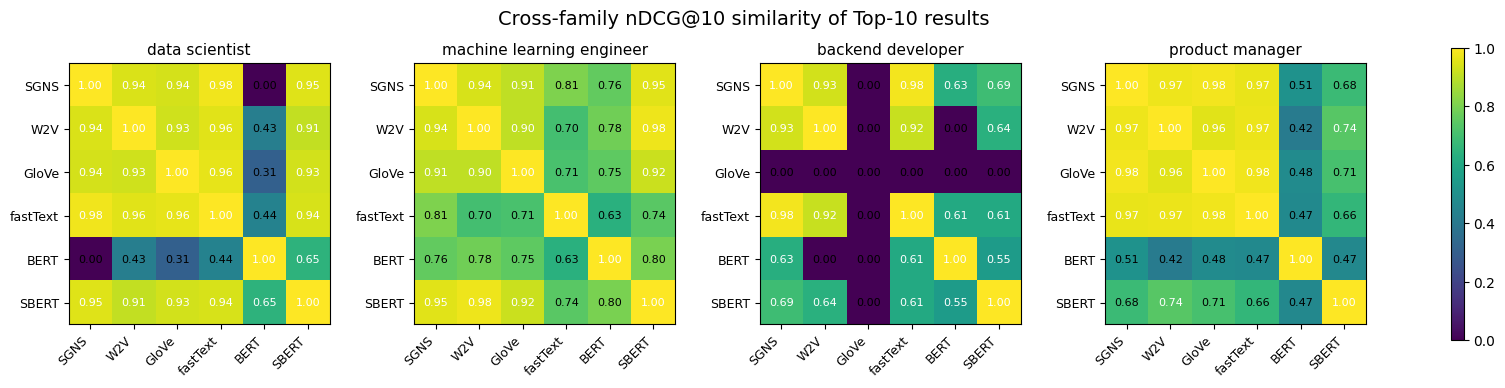

In [73]:
# nDCG
def _rank_map(lst, k):
    """1-based rank map for the first k items of lst."""
    return {w: i+1 for i, w in enumerate(lst[:k])}

def _dcg_at_k(ref_list, cand_rank, k):
    """
    ref_list: list of items (length >= k) used as the 'positions' 1..k
    cand_rank: dict item -> rank in candidate (1-based), for items present in candidate
    """
    # graded relevance from candidate rank
    def rel_from_rank(r):
        return 1.0 / np.log2(r + 1.0)

    gains = []
    for i, item in enumerate(ref_list[:k], start=1):
        if item in cand_rank:
            rel = rel_from_rank(cand_rank[item])
        else:
            rel = 0.0
        gains.append(rel / np.log2(i + 1.0))

    dcg = float(np.sum(gains))

    # ideal DCG: sort the non-zero relevances by their value, place best at top positions
    rels_nonzero = sorted(
        [rel_from_rank(r) for item, r in cand_rank.items() if item in set(ref_list[:k])],
        reverse=True
    )
    idcg_terms = [
        rels_nonzero[j] / np.log2((j + 1) + 1.0)  # j starts at 0 => position j+1
        for j in range(min(len(rels_nonzero), k))
    ]
    idcg = float(np.sum(idcg_terms))
    return dcg / idcg if idcg > 0 else 0.0

def ndcg_sym_at_k(list_a, list_b, k=10):
    """Symmetric nDCG@k between two ranked lists of titles."""
    rank_a = _rank_map(list_a, k)
    rank_b = _rank_map(list_b, k)
    # nDCG(A || B): A provides positions, B provides graded relevance via its ranks
    ndcg_ab = _dcg_at_k(list_a, rank_b, k)
    # nDCG(B || A): symmetrical
    ndcg_ba = _dcg_at_k(list_b, rank_a, k)
    return 0.5 * (ndcg_ab + ndcg_ba)

def cross_matrix(results_topk, family_names, query, k=10):
    """Symmetric nDCG matrix for a given query across families."""
    n = len(family_names)
    M = np.zeros((n, n), dtype=float)
    for i, fa in enumerate(family_names):
        for j, fb in enumerate(family_names):
            A = results_topk[fa].get(query, [])
            B = results_topk[fb].get(query, [])
            M[i, j] = ndcg_sym_at_k(A, B, k=k)
    return pd.DataFrame(M, index=family_names, columns=family_names)

# build nDCG matrices (one per query)

K = 10
family_names = list(results_topk.keys()) 

M_NDCG = {q: cross_matrix(results_topk, family_names, q, k=K).values for q in QUERIES}

# plotting: 1 row with 4 heatmaps + shared colorbar
def _annotate(ax, mat):
    m, n = mat.shape
    mid = (mat.min() + mat.max()) / 2
    for i in range(m):
        for j in range(n):
            ax.text(j, i, f"{mat[i,j]:.2f}",
                    ha="center", va="center",
                    fontsize=8,
                    color="white" if mat[i,j] > mid else "black")

fig, axes = plt.subplots(
    1, 5, figsize=(18, 3.8),
    gridspec_kw={"width_ratios":[1,1,1,1,0.05], "wspace":0.4}
)
fig.suptitle(f"Cross-family nDCG@{K} similarity of Top-10 results", fontsize=14)

vmin, vmax = 0.0, 1.0
im = None
for c, q in enumerate(QUERIES):
    ax = axes[c]
    mat = np.asarray(M_NDCG[q])
    im = ax.imshow(mat, vmin=vmin, vmax=vmax, cmap="viridis")
    ax.set_title(q, fontsize=11)
    ax.set_xticks(range(len(family_names)))
    ax.set_xticklabels(family_names, rotation=45, ha="right", fontsize=9)
    ax.set_yticks(range(len(family_names)))
    ax.set_yticklabels(family_names, fontsize=9)
    _annotate(ax, mat)

# shared colorbar in the last column
cax = axes[-1]
fig.colorbar(im, cax=cax)
plt.show()


### General Observations about the chart: 
Static embeddings (**SGNS/W2V/GloVe/fastText**) produce very similar top-10 rankings for most queries (nDCG@10 ≈ 0.9–1.0), confirming that with decent token coverage, any of these is a strong, cheap baseline for short job titles.

**SBERT** (`all-mpnet-base-v2`) tracks the static families closely and clearly outperforms **base BERT** for similarity search, making it the best “drop-in” model when we want good relevance without task-specific fine-tuning.

**Base BERT** underperforms (anisotropy + not trained for similarity). It’s useful mainly after fine-tuning or with pooling/post-processing tricks.

**Coverage matters**: the “*backend developer*” panel shows GloVe = 0.00 on the diagonal because both tokens are **OOV** in glove.6B.300d.txt, yielding an empty ranking and degenerate nDCG. Use a higher-coverage file (glove.840B.300d.txt) or fall back to fastText (subwords) for query-only OOVs.

### 10) General Conclusion

This notebook built a single, comparable pipeline to retrieve similar job titles using multiple embedding families, our custom **SGNS**, **word2vec**, **GloVe**, **fastText**, **BERT**, and **SBERT**, with the same preprocessing, cosine search, and an nDCG-style agreement metric for side-by-side ranking comparison.

What we learned

**Static embeddings** (SGNS/word2vec/GloVe/fastText) give very similar rankings on short titles when tokens are covered, making them strong, cheap baselines.

**fastText** is the most robust static option for rare/novel words thanks to subword composition.

**SBERT** is the best off-the-shelf neural choice for semantic search on short titles, **base BERT** lags without fine-tuning and benefits less from mean/CLS pooling for retrieval.

Coverage matters: OOV tokens can collapse results for static models, a fallback (fastText or alternative phrasing) prevents degenerate queries.

Our **mini-word2vec** (SGNS) is competitive with large pretrained static models when evaluated under the same tokenizer and scoring.

**Engineering takeaways**

- Keep one canonical tokenizer and L2-normalize all vectors; use mean pooling for BERT-family unless we fine-tune.
- Subset-load large text embeddings (GloVe/fastText) to only needed tokens to save RAM.
- Deduplicate results at display time and compute similarity with batched matrix ops for speed.

**Limitations**

- We compared models to each other (nDCG agreement), not to human relevance labels. Results reflect relative consistency, not absolute correctness.
- Titles are short and domain-specific. No domain fine-tuning or IDF weighting was applied.


----